# GBX Model on LIAR Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Requirements to Run the Notebook

In [ ]:
!pip install transformers
!pip install nltk

     |████████████████████████████████| 890kB 2.9MB/s 
     |████████████████████████████████| 890kB 20.9MB/s 
     |████████████████████████████████| 1.1MB 21.4MB/s 
     |████████████████████████████████| 3.0MB 31.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bc76da7df681feb12a989e5b0713b78995b4fd025fea7841f08a1f7bcda66a1d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# the OG 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight
#NLP Specifics
from nltk import word_tokenize
import nltk
from tokenizers import BertWordPieceTokenizer
from transformers import (AdamW,get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup,RobertaTokenizerFast,DistilBertTokenizerFast,PreTrainedTokenizerFast,AutoModel,
                          DistilBertTokenizerFast,GPT2TokenizerFast,AutoTokenizer,BertTokenizer,TFBertModel,TFOpenAIGPTModel,OpenAIGPTTokenizer,DistilBertTokenizer, 
                          DistilBertConfig,GPT2Config,RobertaConfig,TFDistilBertModel,XLMTokenizer, TFXLMModel,TFBertForSequenceClassification,TFGPT2Model,TFXLMRobertaModel)

#tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import Constant
from tensorflow.keras import regularizers



#other imports
import urllib
import os
import gc
from tqdm import tqdm
import re
import random
from typing import Callable, List, Optional, Union


nltk.download('punkt')
style.use('ggplot')
MAX_LEN=256

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mohammad.Khan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [3]:
uri_train  = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/train.tsv'
uri_valid  = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/valid.tsv'
uri_test  = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/test.tsv'

    
df_train = pd.read_table(uri_train,
                             names = ['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])

    
df_valid = pd.read_table(uri_valid,
                             names =['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])


df_test = pd.read_csv(uri_test, sep='\t', 
                            names =['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue']) 



In [4]:
df_train.drop(['barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c'],axis=1,inplace=True)
df_valid.drop(['barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c'],axis=1,inplace=True)

In [5]:
df_test.drop(['barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c'],axis=1,inplace=True)

In [6]:
set(df_train['label'])

{'barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true'}

<AxesSubplot:>

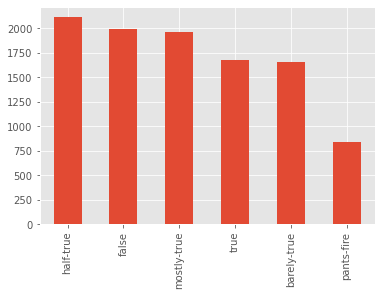

In [7]:
df_train['label'].value_counts().plot(kind='bar')

<AxesSubplot:>

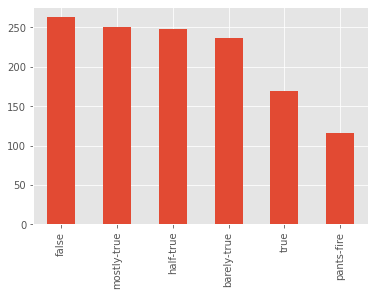

In [8]:
df_valid['label'].value_counts().plot(kind='bar')

In [9]:
def seed_everything(seed):
  random.seed(seed)
  tf.compat.v1.set_random_seed(seed)
  tf.random.set_seed(seed)
seed_everything(123)

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.59.138.2:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.59.138.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.138.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [10]:
def fast_tokenization(text,encode_plus=False):
  attention_mask=[]
  input_ids=[]
  for instance in tqdm(text,desc='Tokenization Process'):
    if encode_plus:
      token_out=fast_tokenizer.encode_plus(instance,return_attention_mask=True,padding='max_length',truncation=True,max_length=MAX_LEN)
      input_ids.append(token_out['input_ids'])
      attention_mask.append(token_out['attention_mask'])
    else:
      token_out=fast_tokenizer.encode(instance)
      input_ids.append(token_out.ids)
      attention_mask.append(token_out.attention_mask)
  return input_ids,attention_mask

In [11]:
X_train={}
X_valid={}
X_test={}

In [12]:
df_train.head()

,id,label,statement,subject,speaker,job,state,party,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN


In [13]:
def stop_word_removal(text):
  stop_word=['The','the','a','A','An','an']
  tokenized_sentence=word_tokenize(text)
  final_tokenized_sentence=[]
  for word in tokenized_sentence:
    if word not in stop_word:
        final_tokenized_sentence.append(word)
  final_tokenized_sentence=' '.join(final_tokenized_sentence)
  return final_tokenized_sentence

In [14]:
def label_numeric(target):
    dic_map={'true':0,'half-true':1,'mostly-true':3,'barely-true':2,'pants-fire':4,'false':5}
    return dic_map[target]

In [15]:
df_train.isnull().sum()

id              0
label           0
statement       0
subject         2
speaker         2
job          2897
state        2208
party           2
venue         102
dtype: int64

In [16]:
df_train.fillna('[UNK]',inplace=True)
df_valid.fillna('[UNK]',inplace=True)
df_test.fillna('[UNK]',inplace=True)

In [17]:
df_train['combine_text_tokenize']=df_train['statement']+' Subject: '+df_train['subject']+' ,Speaker: '+df_train['speaker']+' ,Job: '+df_train['job']+' ,State: '+df_train['state']+' ,Party: ' +df_train['party']+' ,Venue: '+df_train['venue']
df_valid['combine_text_tokenize']=df_valid['statement']+' Subject: '+df_valid['subject']+' ,Speaker: '+df_valid['speaker']+' ,Job: '+df_valid['job']+' ,State: '+df_valid['state']+' ,Party: ' +df_valid['party']+' ,Venue: '+df_valid['venue']
df_test['combine_text_tokenize']=df_test['statement']+' Subject: '+df_test['subject']+' ,Speaker: '+df_test['speaker']+' ,Job: '+df_test['job']+' ,State: '+df_test['state']+' ,Party: ' +df_test['party']+' ,Venue: '+df_test['venue']

In [18]:
df_train.iloc[0,-1]

'Says the Annies List political group supports third-trimester abortions on demand. Subject: abortion ,Speaker: dwayne-bohac ,Job: State representative ,State: Texas ,Party: republican ,Venue: a mailer'

In [19]:
df_train['combine_text_tokenize']=df_train['combine_text_tokenize'].map(stop_word_removal)
df_valid['combine_text_tokenize']=df_valid['combine_text_tokenize'].map(stop_word_removal)
df_test['combine_text_tokenize']=df_test['combine_text_tokenize'].map(stop_word_removal)

In [20]:
df_train['target']=df_train['label'].map(label_numeric)
df_valid['target']=df_valid['label'].map(label_numeric)
df_test['target']=df_test['label'].map(label_numeric)

In [21]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Applies a warmup schedule on a given learning rate decay schedule.

    Args:
        initial_learning_rate (:obj:`float`):
            The initial learning rate for the schedule after the warmup (so this will be the learning rate at the end
            of the warmup).
        decay_schedule_fn (:obj:`Callable`):
            The schedule function to apply after the warmup for the rest of training.
        warmup_steps (:obj:`int`):
            The number of steps for the warmup part of training.
        power (:obj:`float`, `optional`, defaults to 1):
            The power to use for the polynomial warmup (defaults is a linear warmup).
        name (:obj:`str`, `optional`):
            Optional name prefix for the returned tensors during the schedule.
    """

    def __init__(
        self,
        initial_learning_rate: float,
        decay_schedule_fn: Callable,
        warmup_steps: int,
        power: float = 1.0,
        name: str = None,
    ):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:

            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_schedule_fn": self.decay_schedule_fn,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
            "name": self.name,
        }



def create_optimizer(
    init_lr: float,
    num_train_steps: int,
    num_warmup_steps: int,
    min_lr_ratio: float = 0.0,
    adam_epsilon: float = 1e-8,
    weight_decay_rate: float = 0.0,
    include_in_weight_decay: Optional[List[str]] = None,schedule='linear',
):
    """
    Creates an optimizer with a learning rate schedule using a warmup phase followed by a linear decay.

    Args:
        init_lr (:obj:`float`):
            The desired learning rate at the end of the warmup phase.
        num_train_step (:obj:`int`):
            The total number of training steps.
        num_warmup_steps (:obj:`int`):
            The number of warmup steps.
        min_lr_ratio (:obj:`float`, `optional`, defaults to 0):
            The final learning rate at the end of the linear decay will be :obj:`init_lr * min_lr_ratio`.
        adam_epsilon (:obj:`float`, `optional`, defaults to 1e-8):
            The epsilon to use in Adam.
        weight_decay_rate (:obj:`float`, `optional`, defaults to 0):
            The weight decay to use.
        include_in_weight_decay (:obj:`List[str]`, `optional`):
            List of the parameter names (or re patterns) to apply weight decay to. If none is passed, weight decay is
            applied to all parameters except bias and layer norm parameters.
    """
    # Implements linear decay of the learning rate.
    if schedule=='linear':
      lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
          initial_learning_rate=init_lr,
          decay_steps=num_train_steps - num_warmup_steps,
          end_learning_rate=init_lr * min_lr_ratio,
      )
    else:
      lr_schedule=tf.keras.experimental.CosineDecay(
      initial_learning_rate=init_lr, decay_steps=num_train_steps - num_warmup_steps, alpha=0.0, name=None)
      
    if num_warmup_steps:
        lr_schedule = WarmUp(
            initial_learning_rate=init_lr, decay_schedule_fn=lr_schedule, warmup_steps=num_warmup_steps,
        )
    if weight_decay_rate > 0.0:
        optimizer = AdamWeightDecay(
            learning_rate=lr_schedule,
            weight_decay_rate=weight_decay_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=adam_epsilon,
            exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"],
            include_in_weight_decay=include_in_weight_decay,
        )
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=adam_epsilon)
    # We return the optimizer and the LR scheduler in order to better track the
    # evolution of the LR independently of the optimizer.
    return optimizer, lr_schedule

In [22]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [23]:
def accuracy(y_true,y_pred,name):
  y_true=np.argmax(y_true,axis=1)
  y_pred=np.argmax(y_pred,axis=1)
  accuracy=accuracy_score(y_true,y_pred)
  print('The accuracy of the model {} is Accuracy: {:.3%}'.format(name,accuracy))
  print(classification_report(y_true, y_pred, target_names=['true','half-true','barely-true','mostly-true','pants-fire','false']))

In [24]:
def f1_score_m(y_true,y_pred,name):
  y_true=np.argmax(y_true,axis=1)
  y_pred=np.argmax(y_pred,axis=1)
  f1_m=f1_score(y_true,y_pred,average='macro')
  print('The F1-M Score of the model {} is F-1-Score: {:.3%}'.format(name,f1_m))

In [25]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history,main_title):
# Use a log scale to show the wide range of values.
    plt.figure(figsize=(12,10))
    plt.semilogy(list(range(len(history))),  history,
               color='blue', label='Training')
    plt.title(main_title)
    plt.xlabel('Logging Step')
    plt.ylabel('Loss')
  
    plt.legend(title="Log Loss")
    
    
def plot_cm(y_true, y_pred, title):
    ''''
    input y_true-Ground Truth Labels
          y_pred-Predicted Value of Model
          title-What Title to give to the confusion matrix
    
    Draws a Confusion Matrix for better understanding of how the model is working
    
    return None
    
    '''
    
    figsize=(10,10)
    y_true=np.argmax(y_true,axis=1)
    y_pred=np.argmax(y_pred,axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [26]:
true_labels=['true','half-true','barely-true','mostly-true']
false_labels=['false','pants-fire']
high_score_labels=['true','pants-fire']

def score_submission(gold_labels, test_labels):
    score = 0.0
    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance in high_score_labels:
                score += 0.50
        if g_stance in true_labels and t_stance in true_labels:
            score += 0.1
        elif g_stance in false_labels and t_stance in false_labels:
            score += 0.1
        

    return score

def report_score(actual,predicted,name):
    actual=np.argmax(actual,axis=1)
    predicted=np.argmax(predicted,axis=1)
    score = score_submission(actual,predicted)
    best_score = score_submission(actual,actual)
    print('For Model {}'.format(name))
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

In [27]:
def tensorflow_make_train_valid_data(X_train,y_train,X_valid,y_valid,test=False):

      train = (
          tf.data.Dataset
          .from_tensor_slices((X_train, y_train))
          .repeat()
          .shuffle(1024)
          .batch(BATCH_SIZE)
          .prefetch(AUTO))

      valid = (
          tf.data.Dataset
          .from_tensor_slices((X_valid, y_valid))
          .batch(BATCH_SIZE)
          .cache()
          .prefetch(AUTO)
      )
      return train,valid

In [28]:
def make_test_data(X_test):
    test = (
          tf.data.Dataset
          .from_tensor_slices(X_test)
          .batch(BATCH_SIZE)
      )
    return test

In [29]:
fast_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")._tokenizer
fast_tokenizer.enable_padding(length=MAX_LEN)
fast_tokenizer.enable_truncation(max_length=MAX_LEN)


input_ids_distill_bert,attention_mask_distill_bert=fast_tokenization(df_train['combine_text_tokenize'].values)
X_train['input_ids_distill_bert'],X_train['attention_mask_distill_bert']=input_ids_distill_bert,attention_mask_distill_bert
input_ids_distill_bert,attention_mask_distill_bert=fast_tokenization(df_valid['combine_text_tokenize'].values)
X_valid['input_ids_distill_bert'],X_valid['attention_mask_distill_bert']=input_ids_distill_bert,attention_mask_distill_bert

input_ids_distill_bert,attention_mask_distill_bert=fast_tokenization(df_test['combine_text_tokenize'].values)
X_test['input_ids_distill_bert'],X_test['attention_mask_distill_bert']=input_ids_distill_bert,attention_mask_distill_bert


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Tokenization Process: 100%|██████████| 1267/1267 [00:00<00:00, 5498.75it/s]


In [30]:
fast_tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")._tokenizer
fast_tokenizer.enable_padding(length=MAX_LEN)
fast_tokenizer.enable_truncation(max_length=MAX_LEN)

input_ids_gpt_2,attention_mask_gpt_2=fast_tokenization(df_train['combine_text_tokenize'].values)
X_train['input_ids_gpt_2'],X_train['attention_mask_gpt_2']=input_ids_gpt_2,attention_mask_gpt_2
input_ids_gpt_2,attention_mask_gpt_2=fast_tokenization(df_valid['combine_text_tokenize'].values)
X_valid['input_ids_gpt_2'],X_valid['attention_mask_gpt_2']=input_ids_gpt_2,attention_mask_gpt_2

input_ids_gpt_2,attention_mask_gpt_2=fast_tokenization(df_test['combine_text_tokenize'].values)
X_test['input_ids_gpt_2'],X_test['attention_mask_gpt_2']=input_ids_distill_bert,attention_mask_distill_bert


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenization Process: 100%|██████████| 1267/1267 [00:00<00:00, 5826.58it/s]


In [31]:
model_type = 'distilroberta-base'
fast_tokenizer =AutoTokenizer.from_pretrained(model_type)
input_ids_roberta,attention_mask_roberta=fast_tokenization(df_train['combine_text_tokenize'].values,encode_plus=True)
X_train['input_ids_roberta'],X_train['attention_mask_roberta']=input_ids_roberta,attention_mask_roberta
roberta_model_base_input_id,roberta_model_attention_mask=fast_tokenization(df_valid['combine_text_tokenize'].values,encode_plus=True)
X_valid['input_ids_roberta'],X_valid['attention_mask_roberta']=roberta_model_base_input_id,roberta_model_attention_mask

roberta_model_base_input_id,roberta_model_attention_mask=fast_tokenization(df_test['combine_text_tokenize'].values,encode_plus=True)
X_test['input_ids_roberta'],X_test['attention_mask_roberta']=roberta_model_base_input_id,roberta_model_attention_mask



Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenization Process: 100%|██████████| 1267/1267 [00:00<00:00, 3982.39it/s]


In [32]:
y_train=np.array(tf.keras.utils.to_categorical(df_train['target'].values))
y_valid=np.array(tf.keras.utils.to_categorical(df_valid['target'].values))

In [33]:
print(X_train.keys())
print(X_valid.keys())

dict_keys(['input_ids_distill_bert', 'attention_mask_distill_bert', 'input_ids_gpt_2', 'attention_mask_gpt_2', 'input_ids_roberta', 'attention_mask_roberta'])
dict_keys(['input_ids_distill_bert', 'attention_mask_distill_bert', 'input_ids_gpt_2', 'attention_mask_gpt_2', 'input_ids_roberta', 'attention_mask_roberta'])


In [34]:
BATCH_SIZE = 64
EPOCHS=100
LEARNING_RATE=1e-7
BETA_1=0.9
BETA_2=0.999
AUTO = tf.data.experimental.AUTOTUNE
steps_per_epoch=df_train.shape[0]//BATCH_SIZE
total_optimization_steps=int(steps_per_epoch*EPOCHS)
WARM_UP_STEPS=int(0.06*total_optimization_steps)
optimizer_with_schedule,lr_schedule=create_optimizer(init_lr=LEARNING_RATE,num_train_steps=total_optimization_steps,num_warmup_steps=WARM_UP_STEPS,schedule='cosine')
EARLY_STOP=tf.keras.callbacks.EarlyStopping(patience=10)
MAX_LEN=MAX_LEN
LOSS=tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=BETA_1,beta_2=BETA_2)




In [35]:
test=make_test_data(X_test)

In [36]:
def gbx_layers():
    CONFIG_db=DistilBertConfig()
    distill_bert = (
                TFDistilBertModel.from_pretrained('distilbert-base-uncased')
            )
    
    gpt_layer=(
        TFGPT2Model.from_pretrained('distilgpt2')
    )

    roberta_model=(
        TFXLMRobertaModel.from_pretrained('distilroberta-base')
    )




    input_ids_distill_bert = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids_distill_bert")
    attention_mask_distill_bert=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask_distill_bert")

    input_ids_gpt_2 = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids_gpt_2")
    attention_mask_gpt_2=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask_gpt_2")

    input_ids_roberta = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids_roberta")
    attention_mask_roberta=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask_roberta")
        
    
    hidden_state_output_dbert=distill_bert([input_ids_distill_bert,attention_mask_distill_bert])[0]
    hidden_state_output_gpt_2,_=gpt_layer({'input_ids': input_ids_gpt_2, 'attention_mask': attention_mask_gpt_2},past=None)
    hidden_state_output_roberta,_=roberta_model([input_ids_roberta,attention_mask_roberta])
    
    
    
    combine_input_1=tf.keras.layers.concatenate([hidden_state_output_dbert,hidden_state_output_gpt_2,hidden_state_output_roberta],axis=2,name='Concatenate_layer')
    final_input=tf.keras.layers.Conv1D(filters=768,kernel_size=3,padding='same',name='Conv_1d_layer')(combine_input_1)
    

    final_input_1=tf.keras.layers.GlobalAveragePooling1D(name='Average_Pooling_layer')(final_input)
    out = tf.keras.layers.Dense(6, activation='softmax',name='Softmax_Layer')(final_input_1)

    model = tf.keras.Model(inputs=[input_ids_distill_bert,attention_mask_distill_bert,input_ids_gpt_2,attention_mask_gpt_2,input_ids_roberta,attention_mask_roberta], outputs=out)
   
    return model

In [ ]:
def compile_gbx(optim):
  model=gbx_layers()
  model.compile(optimizer=optim,loss=LOSS,metrics='accuracy')
  print(model.summary())
  return model


train,valid=tensorflow_make_train_valid_data(X_train,y_train,X_valid,y_valid)
with strategy.scope():
  model=compile_gbx(optimizer_with_schedule)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
All model checkpoint weights were used when initializing TFGPT2Model.

A

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids_distill_bert (InputLa [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask_distill_bert (In [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask_gpt_2 (InputLaye [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids_gpt_2 (InputLayer)    [(None, 256)]        0                                            
_______________________________________________________________________________________

## GBX Model Run

Following Parameters were used-Run(1)


1.   BATCH_SIZE = 32
2.   EPOCHS=2
3.   LEARNING_RATE=3e-5
4.   BETA_1=0.9-BETA_2=0.999
5.   Scheduler=Linear with Intial Learning Rate of 3e-5
6.   Freezing=No Layer was Freezed
7.   MAX_LEN=256
8.   Trained on TPU(Google Colab)

In [ ]:
history = LossHistory()
model.fit(
      train,steps_per_epoch=steps_per_epoch,
      epochs=EPOCHS,callbacks=[history], validation_data=valid,
)
  

Epoch 1/2
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


  2/320 [..............................] - ETA: 30s - loss: 7.7500 - accuracy: 0.1875WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0135s vs `on_train_batch_end` time: 0.1762s). Check your callbacks.


320/320 [==============================] - ETA: 0s - loss: 1.9289 - accuracy: 0.2336WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0043s vs `on_test_batch_end` time: 0.0464s). Check your callbacks.


320/320 [==============================] - 88s 275ms/step - loss: 1.9289 - accuracy: 0.2336 - val_loss: 1.7209 - val_accuracy: 0.2835
Epoch 2/2
320/320 [==============================] - 63s 197ms/step - loss: 1.6002 - accuracy: 0.3195 - val_loss: 1.6416 - val_accuracy: 0.2991


In [ ]:
y_pred=model.predict(test,verbose=1)
y_true=np.array(tf.keras.utils.to_categorical(df_test['target'].values))

 2/40 [>.............................] - ETA: 3:20WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0043s vs `on_predict_batch_end` time: 0.0454s). Check your callbacks.


40/40 [==============================] - 21s 521ms/step


In [ ]:
saved_history=np.array(history.losses)
np.save('y_pred_gbx_liar_dataset_run(1).npy',y_pred,allow_pickle=True)
np.save('saved_history_liar_dataset_run(1).npy',saved_history)

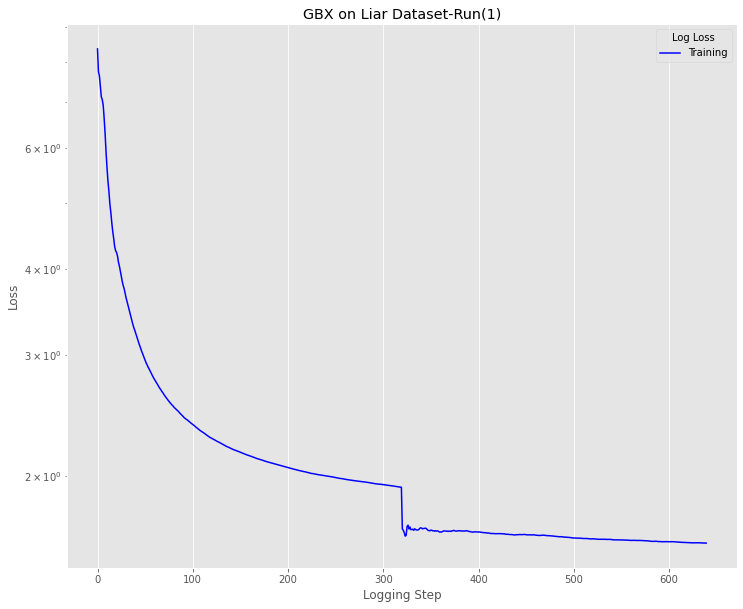

In [ ]:
plot_loss(history.losses,'GBX on Liar Dataset-Run(1)')

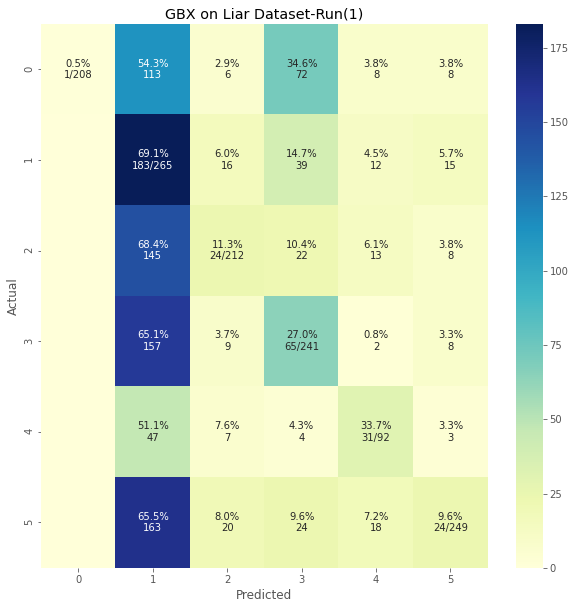

In [ ]:
plot_cm(y_true, y_pred, 'GBX on Liar Dataset-Run(1)')

In [ ]:
accuracy(y_true,y_pred,'GBX on Liar Dataset-Run(1)')

The accuracy of the model GBX on Liar Dataset-Run(1) is Accuracy: 25.888%
              precision    recall  f1-score   support

        true       1.00      0.00      0.01       208
   half-true       0.23      0.69      0.34       265
 barely-true       0.29      0.11      0.16       212
 mostly-true       0.29      0.27      0.28       241
  pants-fire       0.37      0.34      0.35        92
       false       0.36      0.10      0.15       249

    accuracy                           0.26      1267
   macro avg       0.42      0.25      0.22      1267
weighted avg       0.41      0.26      0.21      1267



In [ ]:
f1_score_m(y_true,y_pred,'GBX on Liar Dataset-Run(1)')

The F1-M Score of the model GBX on Liar Dataset-Run(1) is F-1-Score: 21.616%


## GBX Model Run

Following Parameters were used-Run(2)


1.   BATCH_SIZE = 32
2.   EPOCHS=20(Early CallBack)
3.   LEARNING_RATE=3e-5
4.   BETA_1=0.9-BETA_2=0.999
5.   Scheduler=Linear with Intial Learning Rate of 3e-5
6.   Freezing=No Layer was Freezed
7.   MAX_LEN=256
8.   Trained on TPU(Google Colab)

In [ ]:
history = LossHistory()
model.fit(
      train,steps_per_epoch=steps_per_epoch,
      epochs=EPOCHS,callbacks=[history,EARLY_STOP], validation_data=valid,
)
  

Epoch 1/20


  2/320 [..............................] - ETA: 30s - loss: 3.3448 - accuracy: 0.3125WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.1736s). Check your callbacks.


320/320 [==============================] - ETA: 0s - loss: 1.8825 - accuracy: 0.2182WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0043s vs `on_test_batch_end` time: 0.0462s). Check your callbacks.


320/320 [==============================] - 89s 277ms/step - loss: 1.8825 - accuracy: 0.2182 - val_loss: 1.7126 - val_accuracy: 0.2741
Epoch 2/20
320/320 [==============================] - 64s 199ms/step - loss: 1.6810 - accuracy: 0.2730 - val_loss: 1.6611 - val_accuracy: 0.2695
Epoch 3/20
320/320 [==============================] - 64s 201ms/step - loss: 1.5026 - accuracy: 0.3751 - val_loss: 1.7745 - val_accuracy: 0.2804
Epoch 4/20
320/320 [==============================] - 64s 200ms/step - loss: 1.0628 - accuracy: 0.5836 - val_loss: 2.4403 - val_accuracy: 0.2843
Epoch 5/20
320/320 [==============================] - 66s 205ms/step - loss: 0.5026 - accuracy: 0.8165 - val_loss: 3.5361 - val_accuracy: 0.2531
Epoch 6/20
320/320 [==============================] - 65s 203ms/step - loss: 0.1924 - accuracy: 0.9338 - val_loss: 4.0987 - val_accuracy: 0.2710
Epoch 7/20
320/320 [==============================] - 65s 204ms/step - loss: 0.1053 - accuracy: 0.9658 - val_loss: 4.4260 - val_accuracy: 0.2

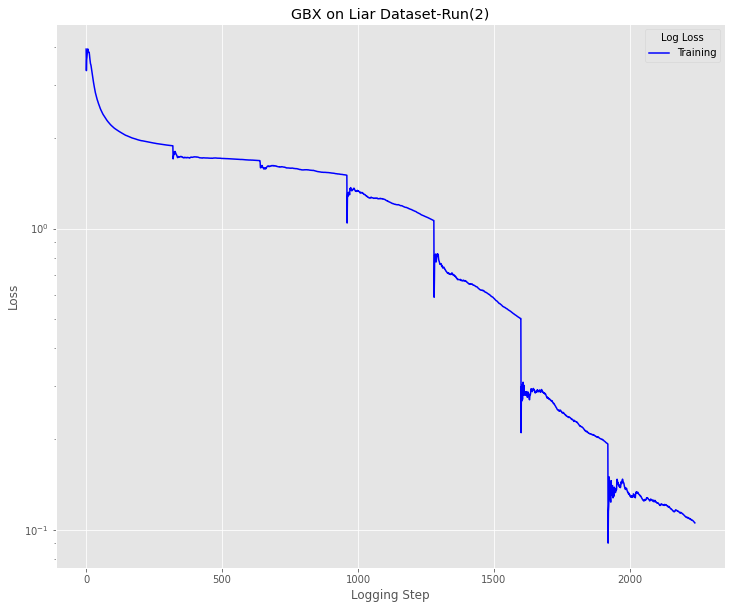

In [ ]:
plot_loss(history.losses,'GBX on Liar Dataset-Run(2)')

In [ ]:
y_pred=model.predict(test,verbose=1)
y_true=np.array(tf.keras.utils.to_categorical(df_test['target'].values))

 1/40 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0047s vs `on_predict_batch_end` time: 0.0433s). Check your callbacks.


40/40 [==============================] - 2s 46ms/step


In [ ]:
saved_history=np.array(history.losses)
np.save('/content/drive/My Drive/Final Research Project/y_pred_gbx_liar_dataset_run(2).npy',y_pred,allow_pickle=True)
np.save('/content/drive/My Drive/Final Research Project/saved_history_liar_dataset_run(2).npy',saved_history)

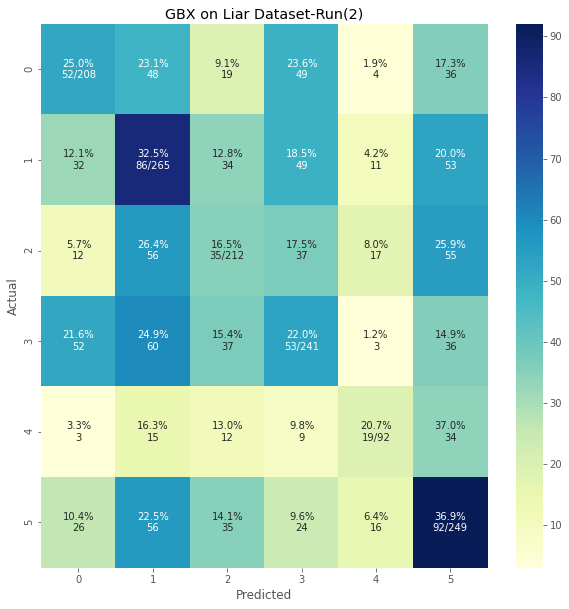

In [ ]:
plot_cm(y_true, y_pred, 'GBX on Liar Dataset-Run(2)')

In [ ]:
accuracy(y_true,y_pred,'GBX on Liar Dataset-Run(2)')

The accuracy of the model GBX on Liar Dataset-Run(2) is Accuracy: 26.598%
              precision    recall  f1-score   support

        true       0.29      0.25      0.27       208
   half-true       0.27      0.32      0.29       265
 barely-true       0.20      0.17      0.18       212
 mostly-true       0.24      0.22      0.23       241
  pants-fire       0.27      0.21      0.23        92
       false       0.30      0.37      0.33       249

    accuracy                           0.27      1267
   macro avg       0.26      0.26      0.26      1267
weighted avg       0.26      0.27      0.26      1267



## GBX Model Run

Following Parameters were used-Run(3)-Need to reduced Overfitting


1.   BATCH_SIZE = 64
2.   EPOCHS=20(Early CallBack)
3.   LEARNING_RATE=3e-5
4.   BETA_1=0.9-BETA_2=0.999
5.   Scheduler=Linear with Intial Learning Rate of 3e-5
6.   Freezing=No Layer was Freezed
7.   MAX_LEN=128
8.   Trained on TPU(Google Colab)
9.   Dropout=0.4
10.  L1 Reg=1e-4
11.  L2 Reg=1e-3

In [ ]:
history = LossHistory()
model.fit(
      train,steps_per_epoch=steps_per_epoch,
      epochs=EPOCHS,callbacks=[history,EARLY_STOP], validation_data=valid,
)
  

Epoch 1/20
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


  2/160 [..............................] - ETA: 14s - loss: 1905.4080 - accuracy: 0.1641WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.1690s). Check your callbacks.


160/160 [==============================] - ETA: 0s - loss: 417.9785 - accuracy: 0.1849WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0050s vs `on_test_batch_end` time: 0.0474s). Check your callbacks.


160/160 [==============================] - 55s 342ms/step - loss: 417.9785 - accuracy: 0.1849 - val_loss: nan - val_accuracy: 0.2095
Epoch 2/20
160/160 [==============================] - 31s 196ms/step - loss: 27.2197 - accuracy: 0.2017 - val_loss: nan - val_accuracy: 0.1970
Epoch 3/20
160/160 [==============================] - 32s 198ms/step - loss: 18.9325 - accuracy: 0.2036 - val_loss: nan - val_accuracy: 0.2181
Epoch 4/20
160/160 [==============================] - 32s 198ms/step - loss: 16.1764 - accuracy: 0.2091 - val_loss: nan - val_accuracy: 0.2040
Epoch 5/20
160/160 [==============================] - 32s 198ms/step - loss: 14.7216 - accuracy: 0.2110 - val_loss: nan - val_accuracy: 0.2204


In [ ]:
y_pred=model.predict(test,verbose=1)
y_true=np.array(tf.keras.utils.to_categorical(df_test['target'].values))

 2/20 [==>...........................] - ETA: 1:32WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0051s vs `on_predict_batch_end` time: 0.0426s). Check your callbacks.


20/20 [==============================] - 19s 947ms/step


In [ ]:
saved_history=np.array(history.losses)
np.save('y_pred_gbx_liar_dataset_run(3).npy',y_pred,allow_pickle=True)
np.save('saved_history_liar_dataset_run(3).npy',saved_history)

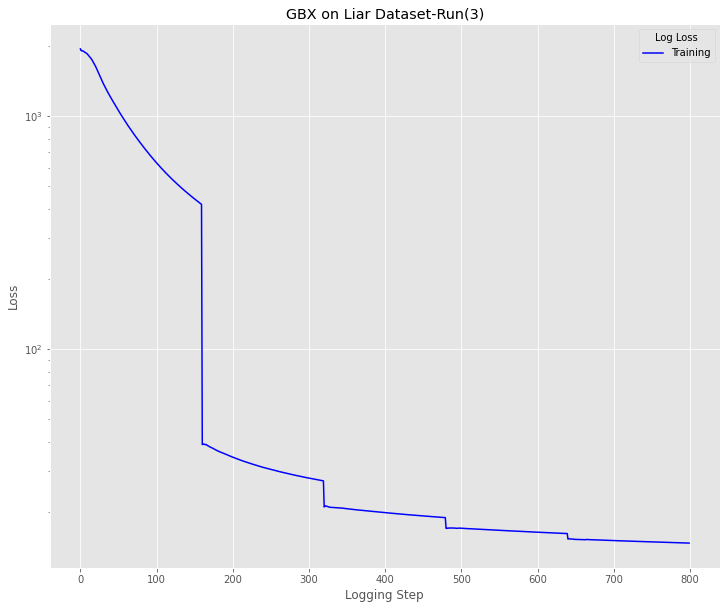

In [ ]:
plot_loss(history.losses,'GBX on Liar Dataset-Run(3)')

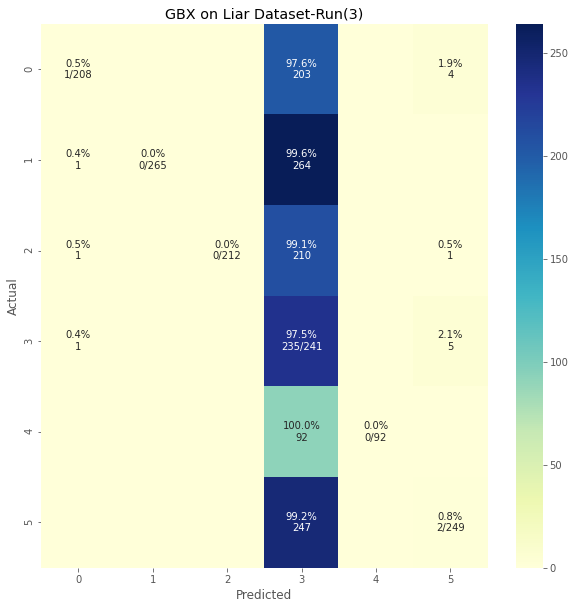

In [ ]:
plot_cm(y_true, y_pred, 'GBX on Liar Dataset-Run(3)')

In [ ]:
accuracy(y_true,y_pred,'GBX on Liar Dataset-Run(3)')

The accuracy of the model GBX on Liar Dataset-Run(3) is Accuracy: 18.785%
              precision    recall  f1-score   support

        true       0.25      0.00      0.01       208
   half-true       0.00      0.00      0.00       265
 barely-true       0.00      0.00      0.00       212
 mostly-true       0.19      0.98      0.32       241
  pants-fire       0.00      0.00      0.00        92
       false       0.17      0.01      0.02       249

    accuracy                           0.19      1267
   macro avg       0.10      0.16      0.06      1267
weighted avg       0.11      0.19      0.06      1267



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Following Parameters were used-Run(4)-Need to reduced Overfitting


1.   BATCH_SIZE = 32
2.   EPOCHS=20(Early CallBack)
3.   LEARNING_RATE=3e-5
4.   BETA_1=0.9-BETA_2=0.999
5.   Scheduler=Linear with Intial Learning Rate of 3e-5
6.   Freezing=Transformer Layers were freezed
7.   MAX_LEN=256
8.   Trained on TPU(Google Colab)
9.   Dropout=0.0
10.  L1 Reg=0.0
11.  L2 Reg=0.0

In [ ]:
## Freezing the Transformers Layers to Reduce the Complexity of the given architecture
for layer in model.layers[6:9]:
  layer.trainable=False

In [ ]:
history = LossHistory()
model.fit(
      train,steps_per_epoch=steps_per_epoch,
      epochs=EPOCHS,callbacks=[history,EARLY_STOP], validation_data=valid,
)
  

Epoch 1/20
  2/320 [..............................] - ETA: 31s - loss: 18.7553 - accuracy: 0.2031WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.1739s). Check your callbacks.


320/320 [==============================] - ETA: 0s - loss: 16.8817 - accuracy: 0.1990WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0053s vs `on_test_batch_end` time: 0.0449s). Check your callbacks.


320/320 [==============================] - 66s 205ms/step - loss: 16.8817 - accuracy: 0.1990 - val_loss: nan - val_accuracy: 0.2017
Epoch 2/20
320/320 [==============================] - 66s 205ms/step - loss: 14.5992 - accuracy: 0.1998 - val_loss: nan - val_accuracy: 0.1994
Epoch 3/20
320/320 [==============================] - 65s 204ms/step - loss: 13.3889 - accuracy: 0.2060 - val_loss: nan - val_accuracy: 0.1939
Epoch 4/20
320/320 [==============================] - 66s 205ms/step - loss: 12.5707 - accuracy: 0.2093 - val_loss: nan - val_accuracy: 0.1955
Epoch 5/20
320/320 [==============================] - 65s 204ms/step - loss: 11.9612 - accuracy: 0.2086 - val_loss: nan - val_accuracy: 0.2142


In [ ]:
y_pred=model.predict(test,verbose=1)
y_true=np.array(tf.keras.utils.to_categorical(df_test['target'].values))

 2/40 [>.............................] - ETA: 3:21WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0057s vs `on_predict_batch_end` time: 0.0453s). Check your callbacks.


40/40 [==============================] - 21s 518ms/step


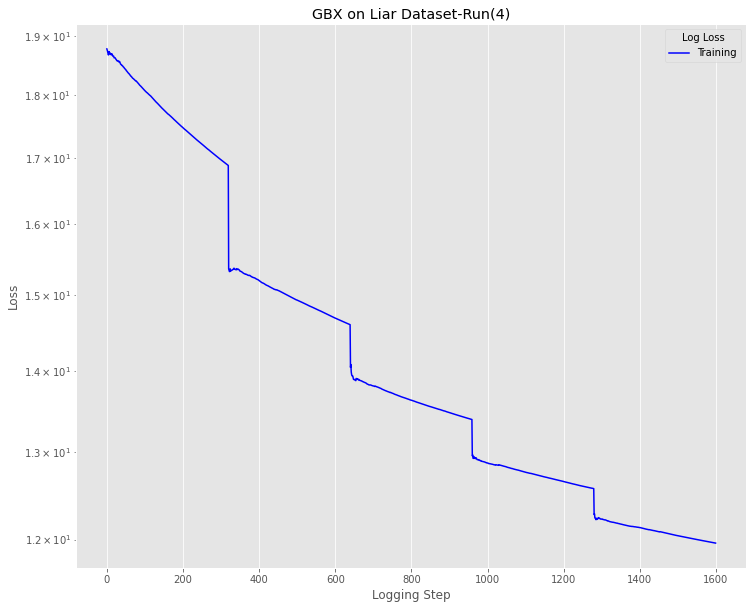

In [ ]:
plot_loss(history.losses,'GBX on Liar Dataset-Run(4)')

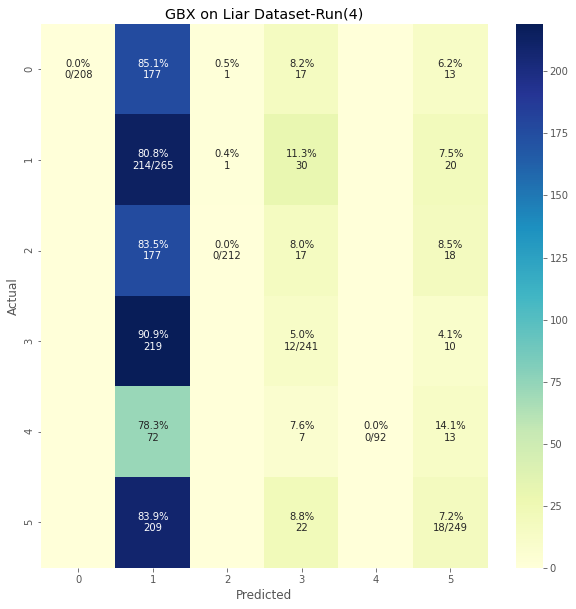

In [ ]:
plot_cm(y_true, y_pred, 'GBX on Liar Dataset-Run(4)')

In [ ]:
accuracy(y_true,y_pred,'GBX on Liar Dataset-Run(4)')

The accuracy of the model GBX on Liar Dataset-Run(4) is Accuracy: 19.258%
              precision    recall  f1-score   support

        true       0.00      0.00      0.00       208
   half-true       0.20      0.81      0.32       265
 barely-true       0.00      0.00      0.00       212
 mostly-true       0.11      0.05      0.07       241
  pants-fire       0.00      0.00      0.00        92
       false       0.20      0.07      0.11       249

    accuracy                           0.19      1267
   macro avg       0.09      0.15      0.08      1267
weighted avg       0.10      0.19      0.10      1267



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Following Parameters were used-Run(5)
1.   BATCH_SIZE = 64
2.   EPOCHS=20(Early CallBack)
3.   LEARNING_RATE=1e-5
4.   BETA_1=0.9-BETA_2=0.999
5.   Scheduler=Cosine with Intial Learning Rate of 1e-5
6.   Freezing=Transformer Layers were freezed
7.   MAX_LEN=256
8.   Trained on TPU(Google Colab)
9.   Balance Weights were Used


In [ ]:
history = LossHistory()
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
model.fit(
      train,steps_per_epoch=steps_per_epoch,
      epochs=EPOCHS,callbacks=[history,EARLY_STOP], validation_data=valid,class_weight=d_class_weights
)

Epoch 1/20
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


  2/160 [..............................] - ETA: 22s - loss: 6.6929 - accuracy: 0.0781WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0242s vs `on_train_batch_end` time: 0.2543s). Check your callbacks.


160/160 [==============================] - ETA: 0s - loss: 2.8277 - accuracy: 0.1576WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0071s vs `on_test_batch_end` time: 0.0687s). Check your callbacks.


160/160 [==============================] - 73s 455ms/step - loss: 2.8277 - accuracy: 0.1576 - val_loss: 1.7607 - val_accuracy: 0.1986
Epoch 2/20
160/160 [==============================] - 46s 287ms/step - loss: 1.7597 - accuracy: 0.2205 - val_loss: 1.7039 - val_accuracy: 0.2555
Epoch 3/20
160/160 [==============================] - 45s 279ms/step - loss: 1.6572 - accuracy: 0.2722 - val_loss: 1.7378 - val_accuracy: 0.2430
Epoch 4/20
160/160 [==============================] - 44s 276ms/step - loss: 1.5671 - accuracy: 0.3221 - val_loss: 1.6807 - val_accuracy: 0.2749
Epoch 5/20
160/160 [==============================] - 44s 275ms/step - loss: 1.4445 - accuracy: 0.3719 - val_loss: 1.8275 - val_accuracy: 0.2383
Epoch 6/20
160/160 [==============================] - 44s 275ms/step - loss: 1.2767 - accuracy: 0.4546 - val_loss: 1.9635 - val_accuracy: 0.2555
Epoch 7/20
160/160 [==============================] - 44s 275ms/step - loss: 1.0769 - accuracy: 0.5424 - val_loss: 2.0776 - val_accuracy: 0.2

In [ ]:
y_pred=model.predict(test,verbose=1)
y_true=np.array(tf.keras.utils.to_categorical(df_test['target'].values))

 2/20 [==>...........................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0077s vs `on_predict_batch_end` time: 0.0659s). Check your callbacks.


20/20 [==============================] - 1s 68ms/step


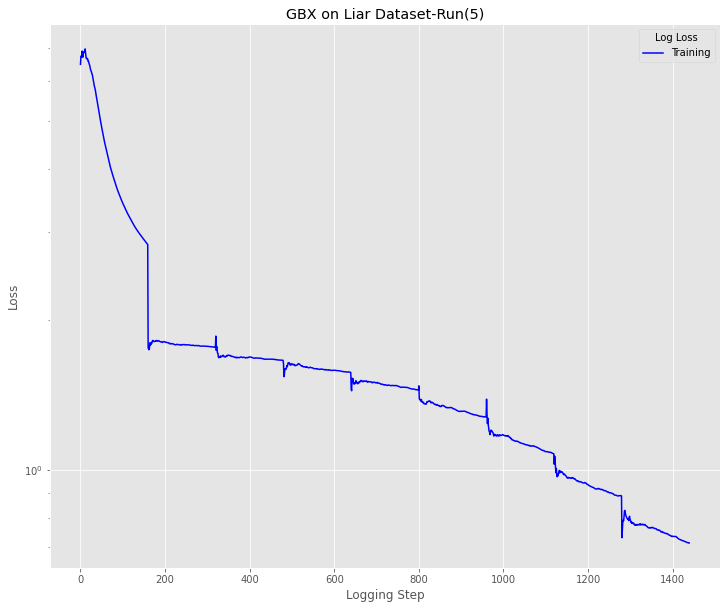

In [ ]:
plot_loss(history.losses,'GBX on Liar Dataset-Run(5)')

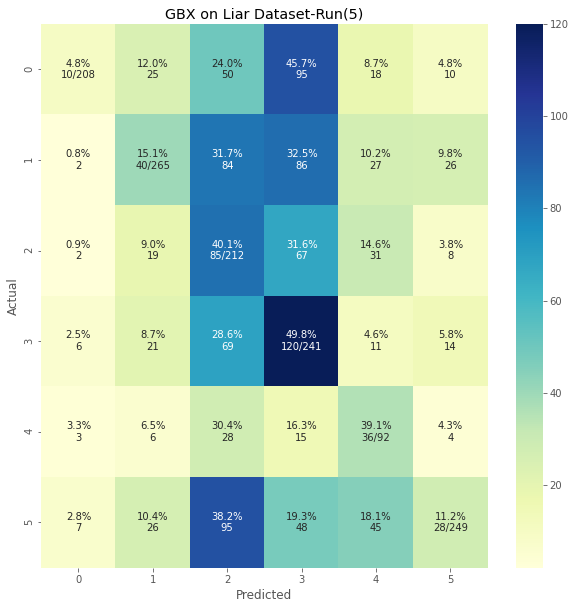

In [ ]:
plot_cm(y_true, y_pred, 'GBX on Liar Dataset-Run(5)')

In [ ]:
accuracy(y_true,y_pred,'GBX on Liar Dataset-Run(5)')

The accuracy of the model GBX on Liar Dataset-Run(5) is Accuracy: 25.178%
              precision    recall  f1-score   support

        true       0.33      0.05      0.08       208
   half-true       0.29      0.15      0.20       265
 barely-true       0.21      0.40      0.27       212
 mostly-true       0.28      0.50      0.36       241
  pants-fire       0.21      0.39      0.28        92
       false       0.31      0.11      0.17       249

    accuracy                           0.25      1267
   macro avg       0.27      0.27      0.23      1267
weighted avg       0.28      0.25      0.22      1267

